In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import correlate
import statsmodels.api as sm
# moje funckje:
import prep
import prsa

# Wczytanie i obróbka danych

Nazwa pliku: r2.csv
Wielkość pliku: 378975
Procent Brakujących danych: 20.53%
Długość najdłuższego odcinka: 138647


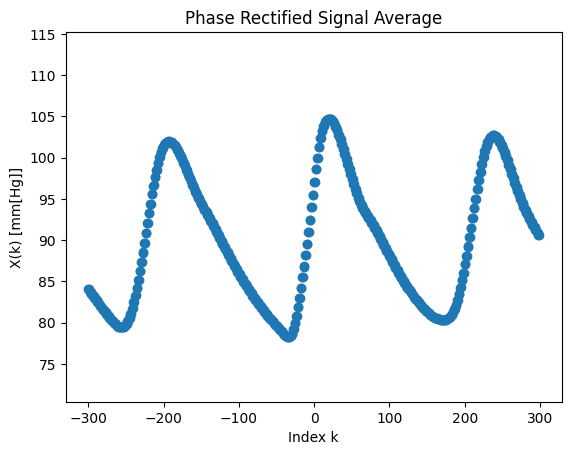

Nazwa pliku: r3.csv
Wielkość pliku: 2378507
Procent Brakujących danych: 30.02%
Długość najdłuższego odcinka: 762522


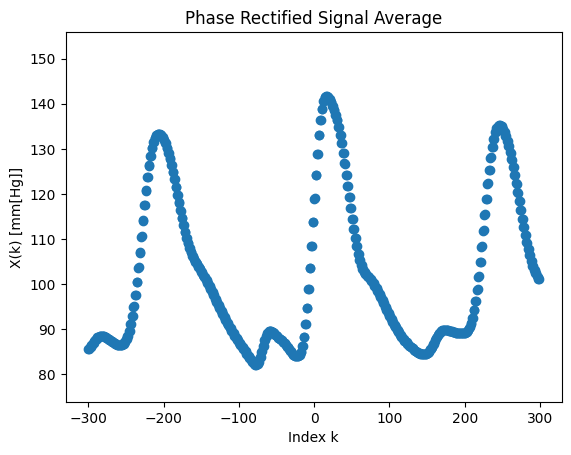

Nazwa pliku: r4.csv
Wielkość pliku: 2621387
Procent Brakujących danych: 48.33%
Długość najdłuższego odcinka: 924625


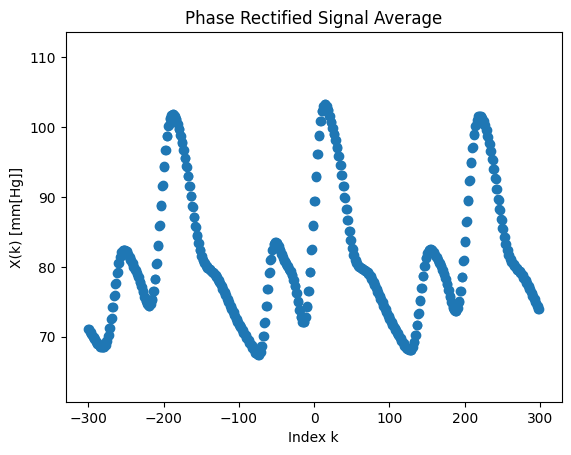

In [12]:
data_path = 'data'
file_names = []
results = []
for filename in os.listdir(data_path):
    if filename.endswith('.csv'):
        # Pełna ścieżka do pliku
        file_path = os.path.join(data_path, filename)
        file_names.append(filename)
    
        df = prep.read_data(file_path)
        print(f'Nazwa pliku: {filename}')
        print(f'Wielkość pliku: {len(df)}')
        print(f'Procent Brakujących danych: {(len(df[df["abp[mmHg]"].isna() == True])/len(df)*100):.2f}%')
        # wykorzystuje jedynie najdłuższy segment aby uniknąć błędów
        df = prep.find_longest_segment(df)
        print(f'Długość najdłuższego odcinka: {len(df)}')
        prsa_result = prsa.calc_optimized(df, 300)
        results.append(prsa_result)
        prsa.plot(prsa_result)




# Obliczanie autokorelacji

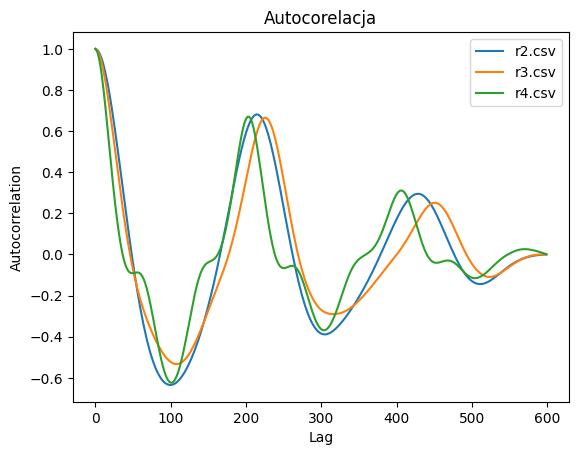

In [34]:
for result, filename in zip(results, file_names):
    acf_result = sm.tsa.acf(result, nlags=len(result) - 1)
    plt.plot(acf_result, label=filename)

plt.xlabel('Lag')  # Label for the x-axis
plt.ylabel('Autocorrelation')  # Label for the y-axis
plt.title(f'Autocorelacja')  # Title for the plot

plt.legend()
plt.show()  # Display the plot

# Funkcja do wizualizacji danych

In [14]:
def plot_and_save_subframes(df, slice_size=24000, discard_remainder=True, nan_kernel=0.2):
    """
    Dzieli ramkę danych na odcinki po slice_size wierszy(domyślnie 2 minuty) i tworzy dla każdego odcinka osobny wykres.
    Odcinki, w których liczba wartości NaN w kolumnie abp[mmHg] przekracza 20%, są pomijane.
    Zachowuje każdy odcinek jako DataFrame w liście.
    
    Args:
    - df: ramka danych do podziału i wizualizacji
    - slice_size: rozmiar każdego odcinka
    - discard_remainder: jeśli True, pomija pozostałą część, która nie załapuje się na idealny podział
    
    Returns:
    Lista odcinków (podramki danych)
    """
    
    number_of_slices = len(df) // slice_size
    if not discard_remainder:
        number_of_slices += 1
    
    subframes = []

    for i in range(number_of_slices):
        start_index = i * slice_size
        end_index = (i+1) * slice_size

        subframe = df.iloc[start_index:end_index]
        
        # Sprawdzenie czy NaN w abp[mmHg] nie przekracza 20%
        percentage_nan = subframe['abp[mmHg]'].isna().mean()
        if percentage_nan <= nan_kernel:
            subframe.plot(y='abp[mmHg]')
            plt.title(f"Odcinek {i+1}")
            plt.show()
            subframes.append(subframe)

    return subframes